### 读取shp文件

In [1]:
import fiona

In [2]:
shps = fiona.open("./MAP/shroad.shp")

In [3]:
shps.schema

{'properties': OrderedDict([('FNODE_', 'int:8'),
              ('TNODE_', 'int:8'),
              ('ID', 'int:8'),
              ('CFCC', 'str:10'),
              ('Length', 'float:19.11'),
              ('RLength', 'float:13.11'),
              ('CityArea', 'int:9'),
              ('RoadName', 'str:50'),
              ('Status1', 'int:4')]),
 'geometry': 'LineString'}

In [4]:
roadList = []
for item in shps:
    orderDict = item.get('properties')
    roadType = 0
    if orderDict['CFCC'] == '高架' or orderDict['CFCC'] == '快速路':
        roadType = 1
    elif orderDict['CFCC'] == '干线主干道' or orderDict['CFCC'] == '主干道' or orderDict['CFCC'] == '其它1':
        roadType = 2
    elif orderDict['CFCC'] == '支路' or orderDict['CFCC'] == '次干道':
        roadType = 3
    elif orderDict['CFCC'] == '形心连接线':
        continue
    if roadType == 0:
        print(orderDict['CFCC'])
    roadData = {'id':orderDict['ID'], 'CFCC':roadType, 'length':orderDict['RLength']}
    roadList.append(roadData)
print(roadList)

[{'id': 36, 'CFCC': 2, 'length': 784.066}, {'id': 47, 'CFCC': 2, 'length': 76.7994}, {'id': 58, 'CFCC': 2, 'length': 1306.56}, {'id': 59, 'CFCC': 2, 'length': 712.503}, {'id': 27, 'CFCC': 2, 'length': 908.375}, {'id': 62, 'CFCC': 2, 'length': 370.342}, {'id': 64, 'CFCC': 2, 'length': 124.597}, {'id': 38, 'CFCC': 2, 'length': 611.248}, {'id': 40, 'CFCC': 2, 'length': 1070.15}, {'id': 6, 'CFCC': 2, 'length': 249.937}, {'id': 70, 'CFCC': 2, 'length': 513.152}, {'id': 73, 'CFCC': 2, 'length': 1004.44}, {'id': 78, 'CFCC': 2, 'length': 903.398}, {'id': 113, 'CFCC': 2, 'length': 155.422}, {'id': 130, 'CFCC': 2, 'length': 451.606}, {'id': 141, 'CFCC': 2, 'length': 726.653}, {'id': 152, 'CFCC': 2, 'length': 665.601}, {'id': 153, 'CFCC': 2, 'length': 838.518}, {'id': 154, 'CFCC': 2, 'length': 1212.71}, {'id': 155, 'CFCC': 2, 'length': 742.812}, {'id': 157, 'CFCC': 2, 'length': 510.517}, {'id': 158, 'CFCC': 2, 'length': 1026.44}, {'id': 159, 'CFCC': 3, 'length': 1590.29}, {'id': 160, 'CFCC': 2, '

### 1、以不高于15min为统计间隔，计算道路网中各路段的平均行程速度；

### 2、分别统计快速路、主干路、次干路和支路中处于严重拥堵运行等级的路段里程比例
|运行等级 | 严重拥堵     |
| ----- |----------|
| 快速路 | V <= 20  |
| 主干路 | V <= 15  |
| 次干路、支路 | V <= 10 |

#### 选取早高峰8:00-9:00和午平峰15:00-16:00
#### 计算对应的文件名

In [5]:
morningFile, afternoonFile = [], []
for i in range(97,109):
    morningFile.append('./FCD-20080917/20080917_' + str(i).zfill(3) + '.txt')

for i in range(181,193):
    afternoonFile.append('./FCD-20080917/20080917_' + str(i).zfill(3) + '.txt')

allFile = []
for i in range(1,289):
    allFile.append('./FCD-20080917/20080917_' + str(i).zfill(3) + '.txt')
allFile

['./FCD-20080917/20080917_001.txt',
 './FCD-20080917/20080917_002.txt',
 './FCD-20080917/20080917_003.txt',
 './FCD-20080917/20080917_004.txt',
 './FCD-20080917/20080917_005.txt',
 './FCD-20080917/20080917_006.txt',
 './FCD-20080917/20080917_007.txt',
 './FCD-20080917/20080917_008.txt',
 './FCD-20080917/20080917_009.txt',
 './FCD-20080917/20080917_010.txt',
 './FCD-20080917/20080917_011.txt',
 './FCD-20080917/20080917_012.txt',
 './FCD-20080917/20080917_013.txt',
 './FCD-20080917/20080917_014.txt',
 './FCD-20080917/20080917_015.txt',
 './FCD-20080917/20080917_016.txt',
 './FCD-20080917/20080917_017.txt',
 './FCD-20080917/20080917_018.txt',
 './FCD-20080917/20080917_019.txt',
 './FCD-20080917/20080917_020.txt',
 './FCD-20080917/20080917_021.txt',
 './FCD-20080917/20080917_022.txt',
 './FCD-20080917/20080917_023.txt',
 './FCD-20080917/20080917_024.txt',
 './FCD-20080917/20080917_025.txt',
 './FCD-20080917/20080917_026.txt',
 './FCD-20080917/20080917_027.txt',
 './FCD-20080917/20080917_02

- 计算早高峰快速路、主干路、次干路和支路中处于严重拥堵运行等级的路段里程比例

In [6]:
def GetRoadData(id, roadList):
    for item in roadList:
        if item['id'] == id:
            return item
    return None

### 判断路段是否处于严重拥堵

In [7]:
import copy
def Congestion(speed, road, SumDis, CongDis):
    sumDis = copy.deepcopy(SumDis)
    congDis = copy.deepcopy(CongDis)
    if speed < 0:
        return "ERROR"
    # 快速路 速度要小于等于20
    if road['CFCC'] == 1:
        sumDis['K'] += road['length']
        if speed <= 20:
            congDis['K'] += road['length']
    # 主干道 速度要小于等于15
    elif road['CFCC'] == 2:
        sumDis['Z'] += road['length']
        if speed <= 15:
            congDis['Z'] += road['length']
    # 次干道 速度要小于等于10
    elif road['CFCC'] == 3:
        sumDis['C'] += road['length']
        if speed <= 10:
            congDis['C'] += road['length']
    return sumDis, congDis

### 3、对各等级道路拥堵里程比例以VKT比例作为权重进行加权，计算确定道路网拥堵里程比例

In [8]:
def CalCKT(roadList):
    VKTdict = {'K':0, 'Z':0, 'C':0}
    for item in roadList:
        if item['CFCC'] == 1:
            VKTdict['K'] += item['length']
        elif item['CFCC'] == 2:
            VKTdict['Z'] += item['length']
        elif item['CFCC'] == 3:
            VKTdict['C'] += item['length']
    sumVKT = VKTdict['K'] + VKTdict['Z'] + VKTdict['C']
    VKTdict['K'] /= sumVKT
    VKTdict['Z'] /= sumVKT
    VKTdict['C'] /= sumVKT
    return VKTdict

### 4、按照道路网拥堵里程比例与道路交通运行指数的转换关系，计算道路交通运行指数，道路交通运行指数取值区间为[0，10]。

In [9]:
def CalTPI(prop):
    if prop <= 0.05:
        return 2 * prop/0.05
    elif prop <= 0.08:
        return 2 + 2 * (prop-0.05)/0.03
    elif prop <= 0.11:
        return 4 + 2 * (prop-0.08)/0.02
    elif prop <= 0.14:
        return 6 + 2 * (prop-0.11)/0.03
    elif prop <= 0.24:
        return 8 + 2 * (prop-0.14)/0.1
    else:
        return 10

In [10]:
fittness = []

In [11]:
import pandas as pd
weight = CalCKT(roadList)
time = 5
for file in allFile:
    sumDis = {'K':0, 'Z':0, 'C':0}
    congDis = {'K':0, 'Z':0, 'C':0}
    df = pd.read_csv(file, header=None)
    for i, data in df.iterrows():
        # 根据id查找道路 获取道路信息
        road = GetRoadData(data[0], roadList)
        if road is None:
            continue
        else:
            a = Congestion(data[1], road, sumDis, congDis)
            if not a == "ERROR":
                sumDis = copy.deepcopy(a[0])
                congDis = copy.deepcopy(a[1])
            b = Congestion(data[2], road, sumDis, congDis)
            if not b == "ERROR":
                sumDis = copy.deepcopy(b[0])
                congDis = copy.deepcopy(b[1])
    prop = weight['K'] * congDis['K']/sumDis['K'] + weight['Z'] * congDis['Z']/sumDis['Z'] + weight['C'] * congDis['C']/sumDis['C']
    TPI = CalTPI(prop)
    print("INFO: Time[%2d]严重拥堵里程比例-快速路:%6.3f  主干道:%6.3f  支路:%6.3f  路网总体加权拥堵比例:%6.3f  道路交通运行指数%.2f "% (time, congDis['K']/sumDis['K'], congDis['Z']/sumDis['Z'], congDis['C']/sumDis['C'], prop, TPI))
    time += 5
    fittness.append(TPI)

INFO: Time[ 5]严重拥堵里程比例-快速路: 0.010  主干道: 0.052  支路: 0.061  路网总体加权拥堵比例: 0.047  道路交通运行指数1.89 
INFO: Time[10]严重拥堵里程比例-快速路: 0.002  主干道: 0.049  支路: 0.055  路网总体加权拥堵比例: 0.042  道路交通运行指数1.69 
INFO: Time[15]严重拥堵里程比例-快速路: 0.009  主干道: 0.055  支路: 0.060  路网总体加权拥堵比例: 0.048  道路交通运行指数1.91 
INFO: Time[20]严重拥堵里程比例-快速路: 0.020  主干道: 0.064  支路: 0.059  路网总体加权拥堵比例: 0.053  道路交通运行指数2.22 
INFO: Time[25]严重拥堵里程比例-快速路: 0.016  主干道: 0.059  支路: 0.051  路网总体加权拥堵比例: 0.047  道路交通运行指数1.90 
INFO: Time[30]严重拥堵里程比例-快速路: 0.015  主干道: 0.050  支路: 0.057  路网总体加权拥堵比例: 0.046  道路交通运行指数1.84 
INFO: Time[35]严重拥堵里程比例-快速路: 0.029  主干道: 0.057  支路: 0.063  路网总体加权拥堵比例: 0.054  道路交通运行指数2.26 
INFO: Time[40]严重拥堵里程比例-快速路: 0.013  主干道: 0.060  支路: 0.068  路网总体加权拥堵比例: 0.054  道路交通运行指数2.26 
INFO: Time[45]严重拥堵里程比例-快速路: 0.009  主干道: 0.056  支路: 0.053  路网总体加权拥堵比例: 0.045  道路交通运行指数1.81 
INFO: Time[50]严重拥堵里程比例-快速路: 0.017  主干道: 0.055  支路: 0.047  路网总体加权拥堵比例: 0.045  道路交通运行指数1.78 
INFO: Time[55]严重拥堵里程比例-快速路: 0.027  主干道: 0.056  支路: 0.050  路网总体加权拥堵比例: 0.048  道路交通运行指数1.92 

In [12]:
fittness

[1.8892524411989602,
 1.685955497526719,
 1.9134706857555188,
 2.2150639104981944,
 1.8987374916828414,
 1.842236292040993,
 2.256203547765443,
 2.2580953970601767,
 1.813687855726907,
 1.7849690286726283,
 1.9243348533395688,
 2.0137856859632284,
 2.0733081172363796,
 6.885333250029976,
 8.095722377185991,
 5.274969732764096,
 3.5300359661209617,
 3.1260453729953923,
 3.598108689669395,
 3.790877222732415,
 3.809116249907149,
 3.071231089402252,
 3.8887533863303116,
 3.5396441592985672,
 3.9431360035044754,
 4.178433648383276,
 3.8340191574895037,
 4.803576398508819,
 4.472915753570785,
 3.981595940771507,
 5.502062498147283,
 5.462756785541812,
 5.948164279457666,
 6.274186513759874,
 5.833352042974309,
 6.0986407974230055,
 6.771888919049266,
 6.758838425885489,
 6.4569273364707644,
 6.813790071728896,
 6.219297160499661,
 6.425455295082127,
 7.691489468239437,
 8.077242764008044,
 8.208580643841287,
 7.639846519582095,
 7.883138989590702,
 6.852400367642319,
 6.883947216115591,
 7.

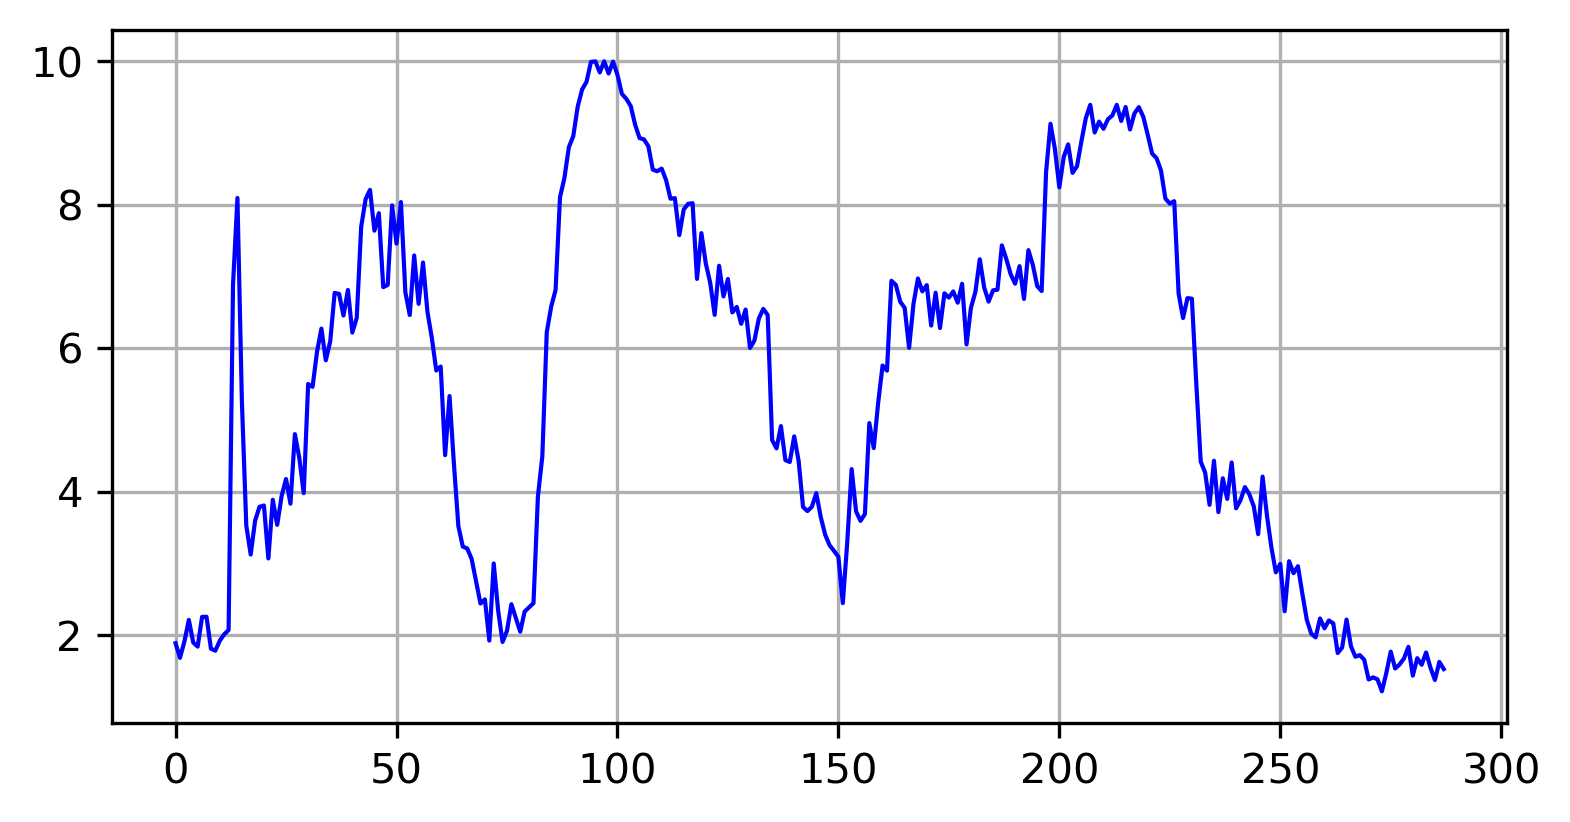

In [13]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(6, 3), dpi=300)
x = list(range(len(fittness)))
y = fittness
plt.plot(x, y, lw=1, ls='-', c='b')
plt.plot()
plt.grid()
plt.show()
fig.savefig("画布.jpg")